# PROIECT - ETAPA 1


# Biblioteci necesare


In [14]:
import os
import random
import zipfile
import copy
import warnings
from collections import Counter
import shutil
from glob import glob
import itertools
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold


from PIL import Image
from torchvision import transforms
import cv2
from scipy.ndimage import gaussian_filter


import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR

from torchsummary import summary


from sklearn.metrics import classification_report, confusion_matrix


## Extragere date

In [19]:
def extract_dataset(zip_path, extract_to):
    
    if not os.path.exists(extract_to):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Datele au fost extrase în directorul: {extract_to}")
    else:
        print(f"Datele sunt deja extrase în directorul: {extract_to}")

extract_dataset(zip_path = 'archive.zip',extract_to = 'data')

Datele au fost extrase în directorul: data


#  BrainTumorDataset

In [20]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        
        self.root_dir = root_dir
        self.transform = transform
        
        self.image_paths = []
        self.labels = []

        for label, category in enumerate(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']):
            category_dir = os.path.join(root_dir, category)
            if os.path.exists(category_dir):
                for img_name in os.listdir(category_dir):
                    img_path = os.path.join(category_dir, img_name)
                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        
        # lazy loading
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        
        # transformari
        if self.transform:
            image = self.transform(image)
        
        # label
        label = self.labels[idx]
        
        return image, label


##


## Impartirea setului de antrenare

In [21]:
def k_fold_split_final(data_dir, categories, k=5, random_state=42):

    train_dir = os.path.join(data_dir, 'Training')
    final_train_dir = os.path.join(data_dir, 'Final_Training')
    final_val_dir = os.path.join(data_dir, 'Final_Validation')
    
    all_images = []
    labels = []
    
    for label, category in enumerate(categories):
        category_dir = os.path.join(train_dir, category)
        if os.path.exists(category_dir):
            images = glob(os.path.join(category_dir, '*'))
            all_images.extend(images)
            labels.extend([label] * len(images)) 
    
    if len(all_images) < k:
        print("Not enough images to apply K-Fold.")
        return
    
    # StratifiedKFold for class distribution
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)
    
    final_train_images = []
    final_val_images = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(all_images, labels)):
        #  first fold for validation; the rest for training
        if fold == 0:
            final_val_images = [all_images[i] for i in val_idx]
            final_train_images = [all_images[i] for i in train_idx]
            break  

    # directories for training and validation sets
    for dir_path in [final_train_dir, final_val_dir]:
        for category in categories:
            os.makedirs(os.path.join(dir_path, category), exist_ok=True)
    
    # Copy images to the training directory
    for img_path in final_train_images:
        category = os.path.basename(os.path.dirname(img_path))
        dest_path = os.path.join(final_train_dir, category, os.path.basename(img_path))
        shutil.copy(img_path, dest_path)  
    
    # Copy images to the validation directory
    for img_path in final_val_images:
        category = os.path.basename(os.path.dirname(img_path))
        dest_path = os.path.join(final_val_dir, category, os.path.basename(img_path))
        shutil.copy(img_path, dest_path)  

    print(f"\nFinal training set contains {len(final_train_images)} images.")
    print(f"Final validation set contains {len(final_val_images)} images.")

data_dir = 'data'
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Split data
k_fold_split_final(data_dir, categories, k=5)

testing_dir = os.path.join(data_dir, 'Testing')
testing_image_count = 0
for category in categories:
        category_dir = os.path.join(testing_dir, category)
        if os.path.exists(category_dir):
            category_images = glob(os.path.join(category_dir, '*'))
            testing_image_count += len(category_images)

print(f"\nTesting set contains {testing_image_count} images in total.")




Final training set contains 2296 images.
Final validation set contains 574 images.

Testing set contains 394 images in total.


## Vizualizarea distributei claselor

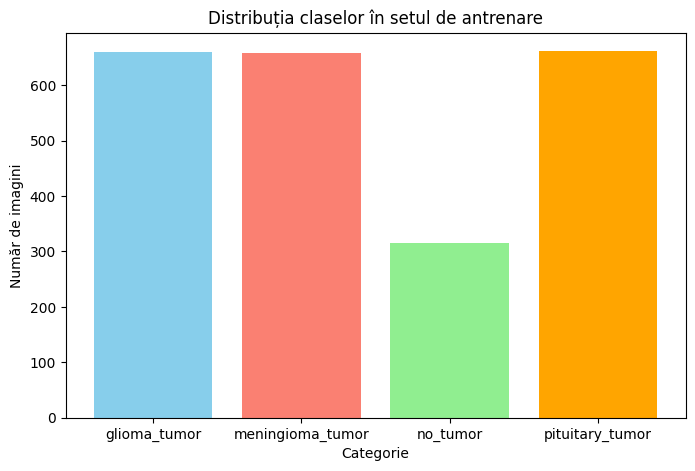

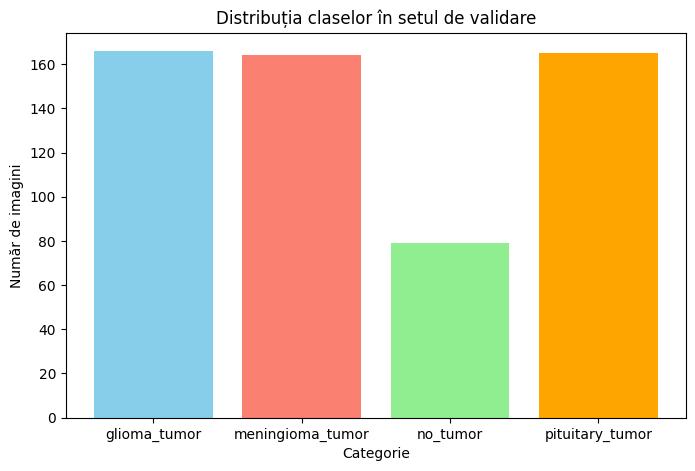

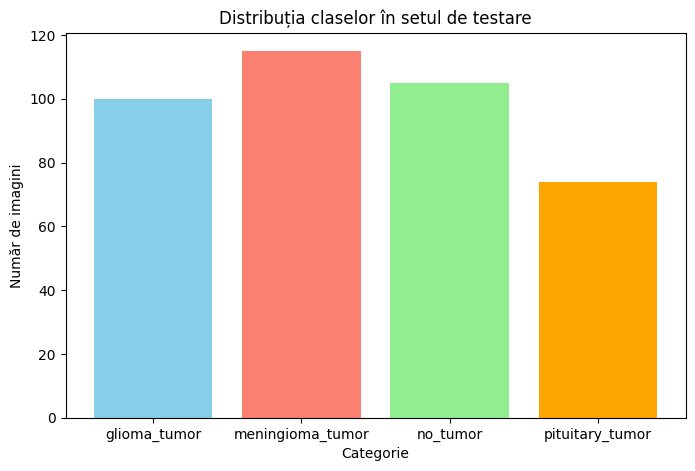

In [22]:
def get_class_distribution(dataset_dir, categories):
    distribution = Counter()
    for category in categories:
        category_dir = os.path.join(dataset_dir, category)
        if os.path.exists(category_dir):
            num_images = len(os.listdir(category_dir))
            distribution[category] = num_images
    return distribution

data_dir = 'data'
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

train_dir = os.path.join(data_dir, 'Final_Training')
val_dir = os.path.join(data_dir, 'Final_Validation')
test_dir = os.path.join(data_dir, 'Testing')

train_distribution = get_class_distribution(train_dir, categories)
val_distribution = get_class_distribution(val_dir, categories)
test_distribution = get_class_distribution(test_dir, categories)

def plot_distribution(distribution, title):
    labels, values = zip(*distribution.items())
    plt.figure(figsize=(8, 5))
    plt.bar(labels, values, color=['skyblue', 'salmon', 'lightgreen', 'orange'])
    plt.title(title)
    plt.xlabel('Categorie')
    plt.ylabel('Număr de imagini')
    plt.show()

# Vizualizăm distribuțiile
plot_distribution(train_distribution, 'Distribuția claselor în setul de antrenare')
plot_distribution(val_distribution, 'Distribuția claselor în setul de validare')
plot_distribution(test_distribution, 'Distribuția claselor în setul de testare')


## Vizualizare imagini

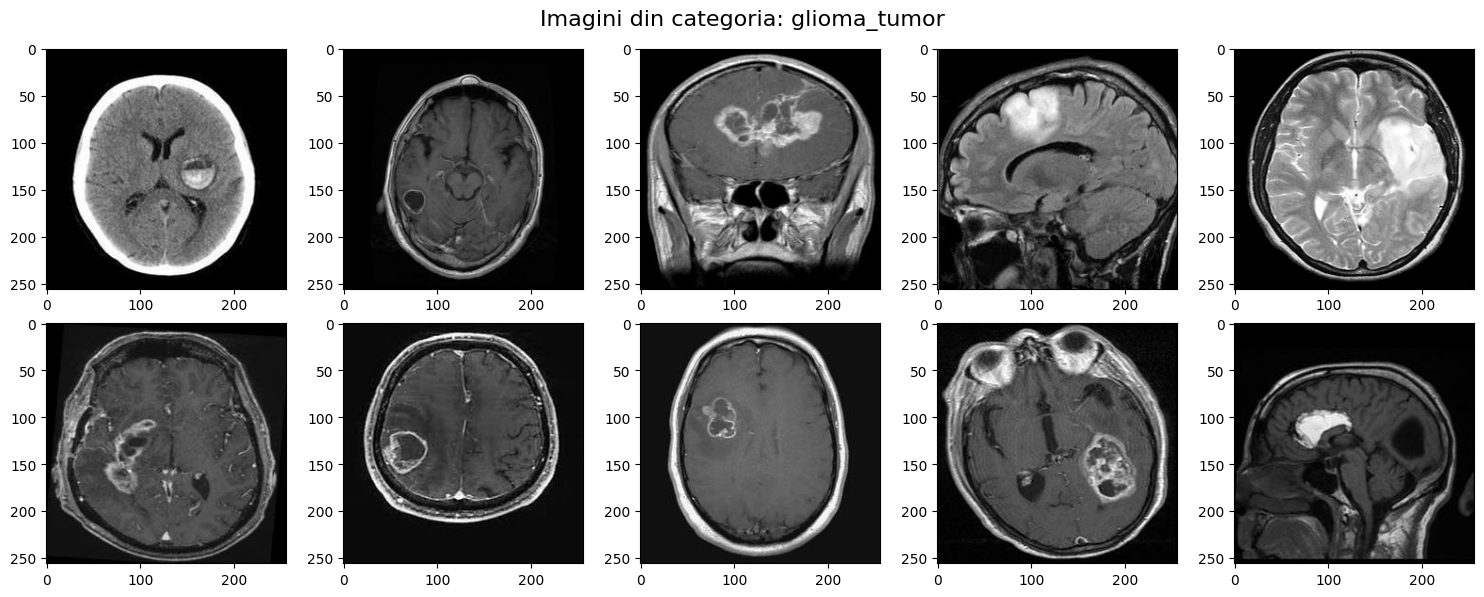

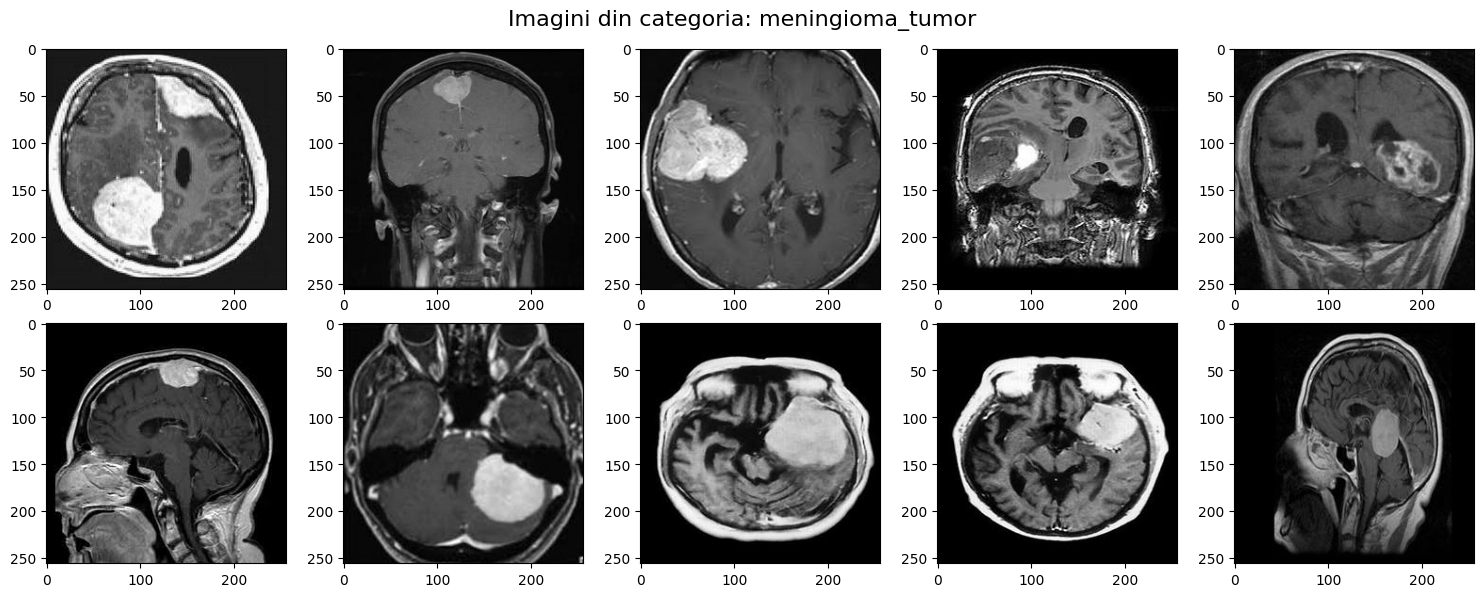

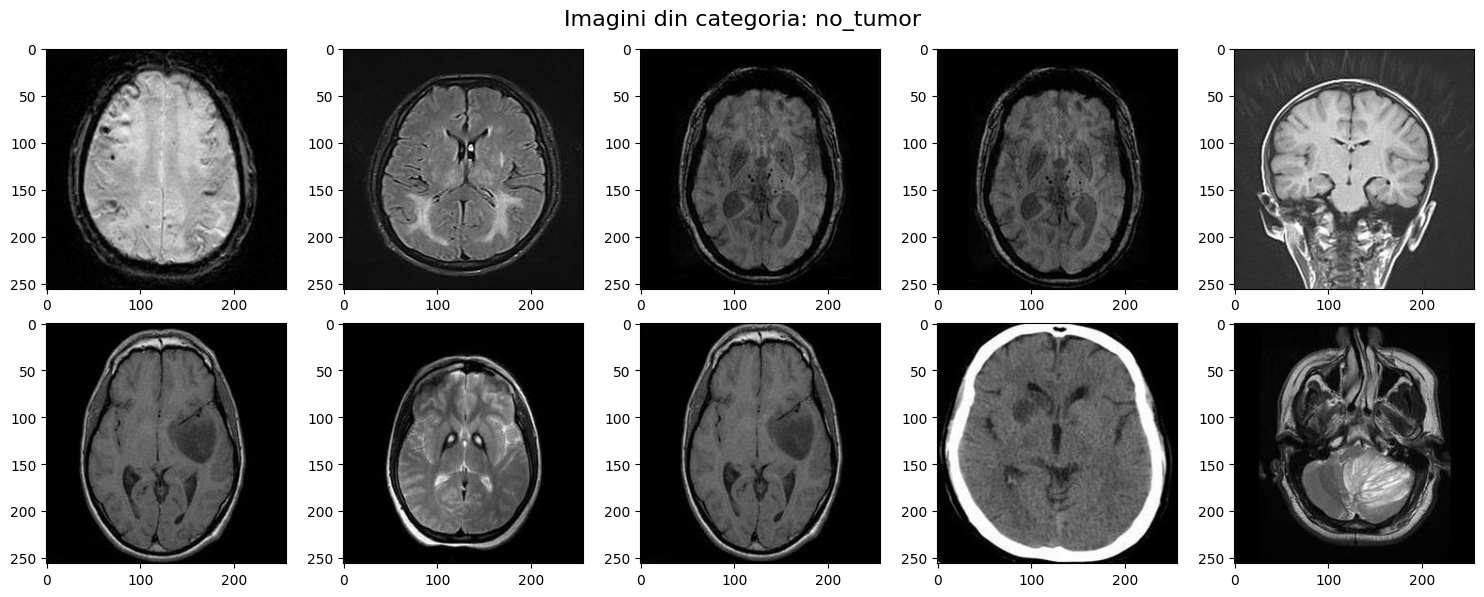

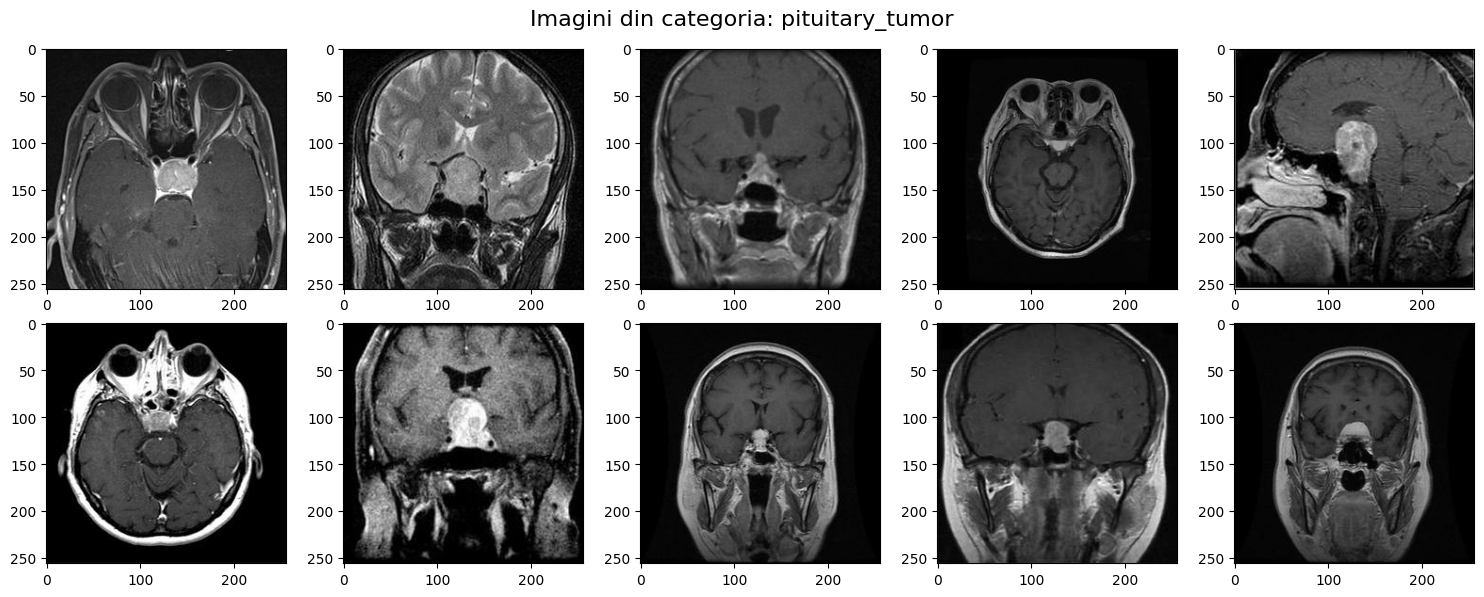

In [27]:
def display_sample_images(data_dir, categories, samples_per_category):
  
    for category in categories:

        category_path = os.path.join(data_dir, category)
        images = glob(os.path.join(category_path, '*'))
        
        num_images_to_display = min(samples_per_category, len(images))
        selected_images = random.sample(images, num_images_to_display)
        
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        fig.suptitle(f'Imagini din categoria: {category}', fontsize=16)
        
        for i, img_path in enumerate(selected_images):
            img = Image.open(img_path) 
            row, col = divmod(i, 5)
            axes[row, col].imshow(img)
            
        plt.tight_layout()
        plt.show()

data_dir = 'data/Testing'
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

display_sample_images(data_dir, categories, samples_per_category=10)



## Verificare si uniformizare

Numărul de imagini găsite cu probleme în fiecare set:
Final_Training: 0 imagini cu canale non-uniforme, 2286 imagini cu dimensiuni non-uniforme.
Final_Validation: 0 imagini cu canale non-uniforme, 569 imagini cu dimensiuni non-uniforme.
Testing: 0 imagini cu canale non-uniforme, 391 imagini cu dimensiuni non-uniforme.


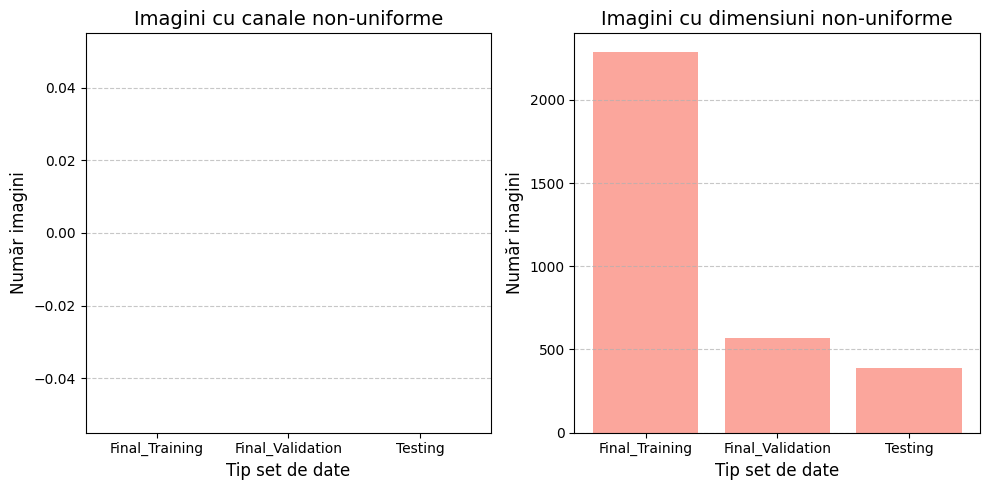

In [ ]:
def check_and_fix_images(data_dir, categories, dataset_types, target_size=(256, 256)):
    all_stats = {}
    
    for dataset_type in dataset_types:
        stats = {
            'non_uniform_channels_dataset': 0,
            'non_uniform_size_dataset': 0,
        }
        for category in categories:
            category_path = os.path.join(data_dir, dataset_type, category)
            images = glob(os.path.join(category_path, '*'))
            
            for img_path in images:
                img = Image.open(img_path)
                img_array = np.array(img)
                
                # Verificăm și uniformizăm numărul de canale
                if img_array.ndim != 3:
                    img = Image.fromarray(img_array)
                    img = img.convert('RGB')
                    stats['non_uniform_channels_dataset'] += 1
                    img_array = np.array(img)

                # Verificăm dimensiunile imaginii și le uniformizăm
                if img.size != target_size:
                    img = img.resize(target_size, Image.LANCZOS)
                    stats['non_uniform_size_dataset'] += 1

                # Normalizare imagine
                img_array = np.array(img) / 255.0
                img.save(img_path)
                
        all_stats[dataset_type] = stats

    return all_stats

data_dir = 'data'
categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
dataset_types = ['Final_Training', 'Final_Validation', 'Testing']

# Obținem raportul
report = check_and_fix_images(data_dir, categories, dataset_types, target_size=(256, 256))

dataset_labels = list(report.keys())
non_uniform_channels = [report[ds]['non_uniform_channels_dataset'] for ds in dataset_labels]
non_uniform_size = [report[ds]['non_uniform_size_dataset'] for ds in dataset_labels]

print("Numărul de imagini găsite cu probleme în fiecare set:")
for ds in dataset_labels:
    print(f"{ds}: {report[ds]['non_uniform_channels_dataset']} imagini cu canale non-uniforme, "
          f"{report[ds]['non_uniform_size_dataset']} imagini cu dimensiuni non-uniforme.")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(dataset_labels, non_uniform_channels, color='skyblue', alpha=0.7)
plt.title('Imagini cu canale non-uniforme', fontsize=14)
plt.ylabel('Număr imagini', fontsize=12)
plt.xlabel('Tip set de date', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.bar(dataset_labels, non_uniform_size, color='salmon', alpha=0.7)
plt.title('Imagini cu dimensiuni non-uniforme', fontsize=14)
plt.ylabel('Număr imagini', fontsize=12)
plt.xlabel('Tip set de date', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustăm layout-ul graficelor
plt.tight_layout()
plt.show()


## Preprocesare + normalizare

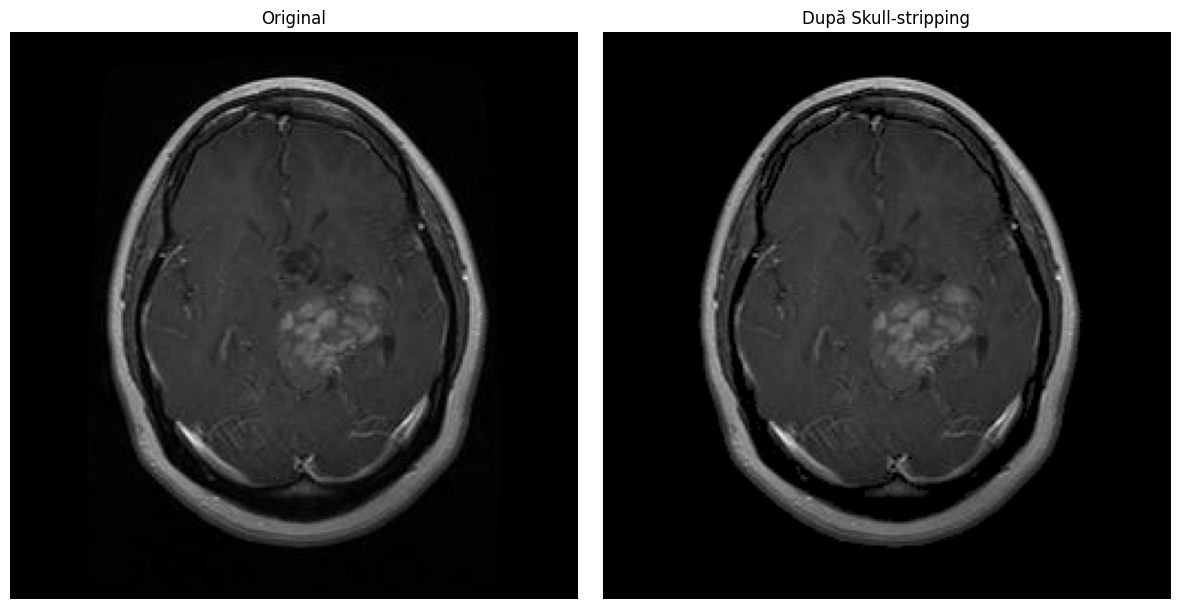

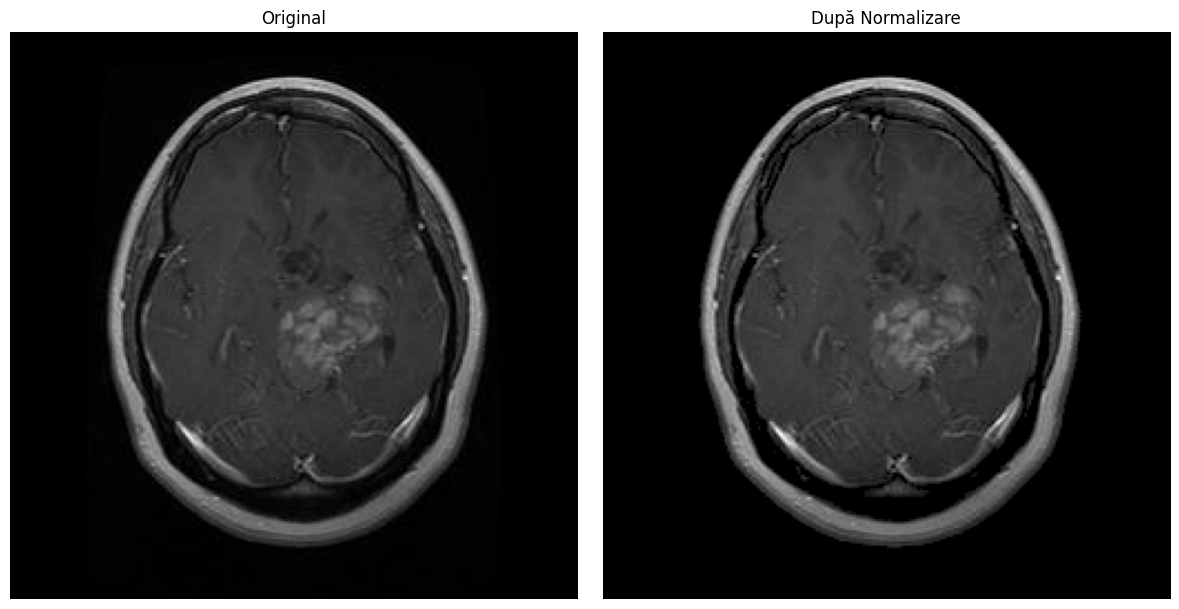

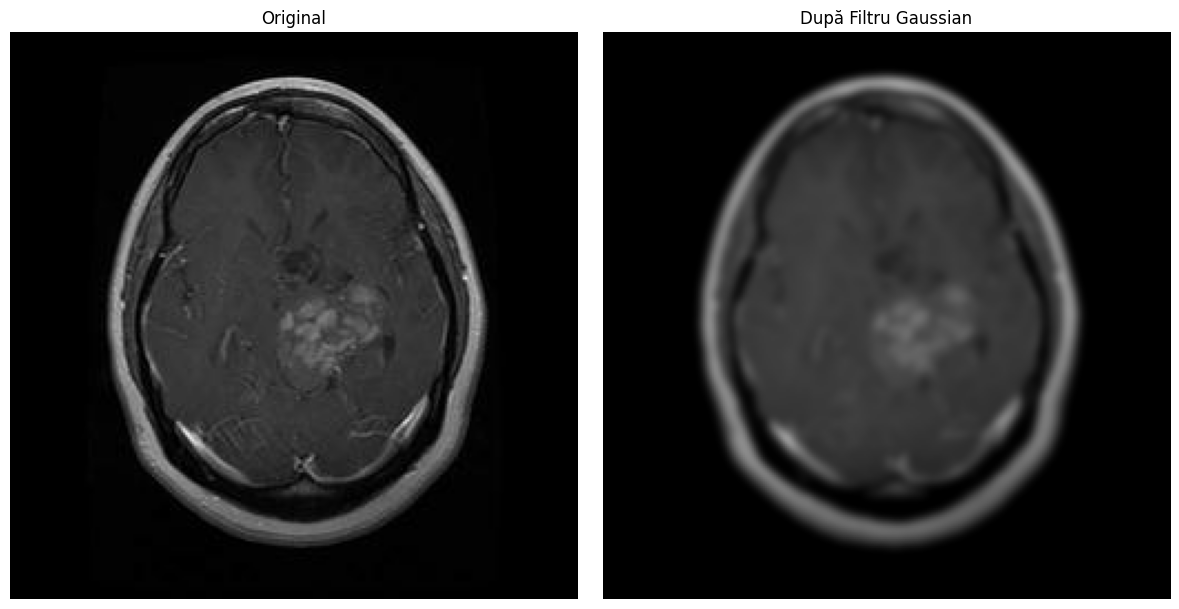

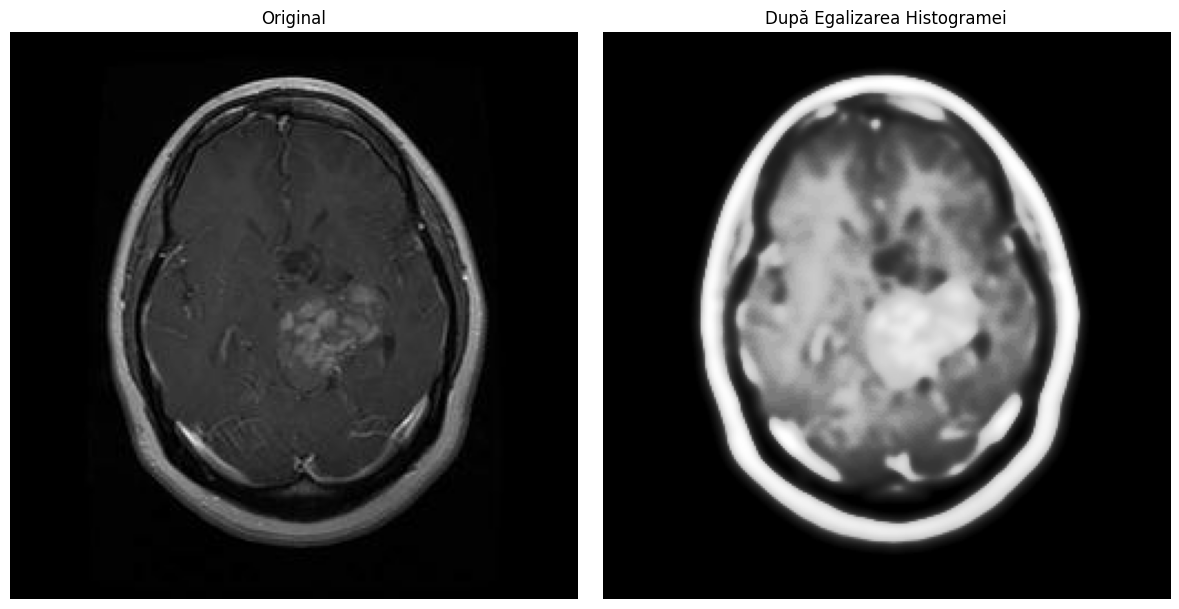

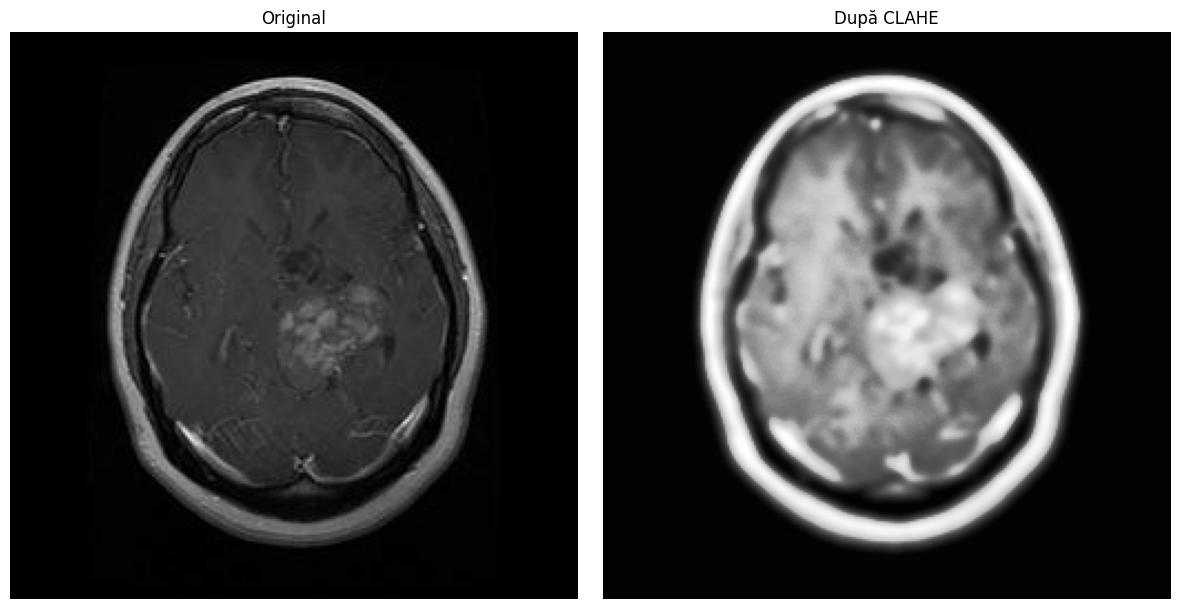

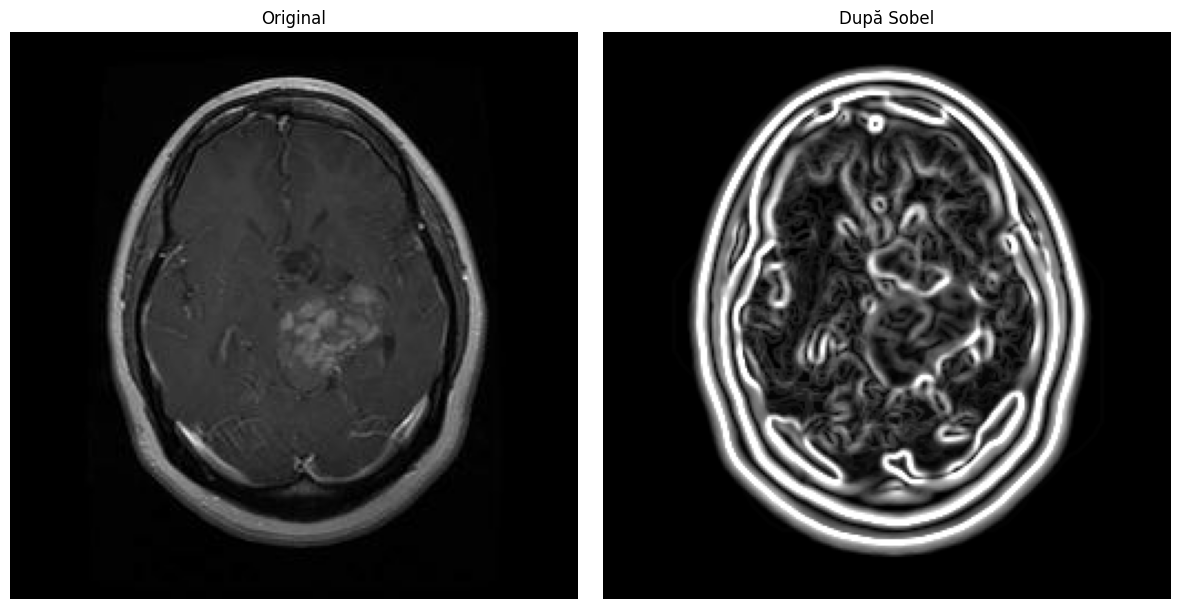

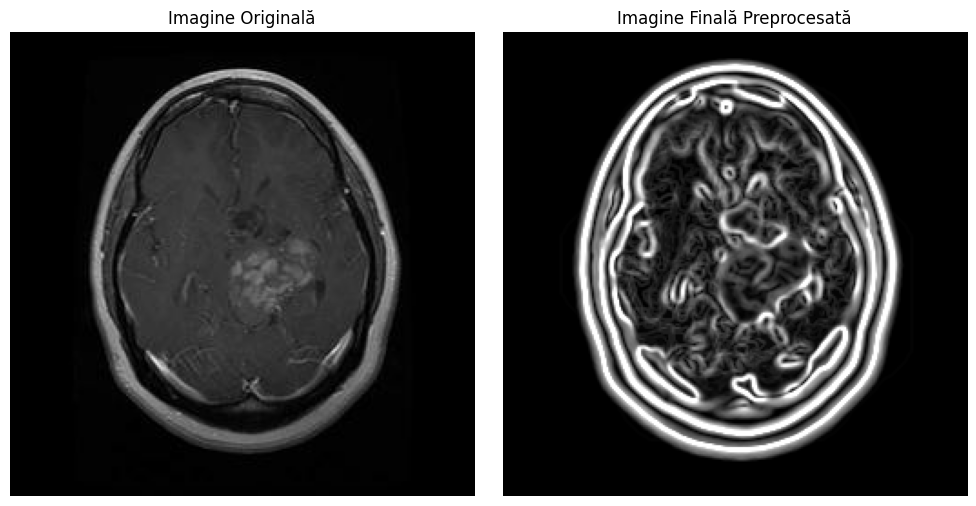

In [ ]:
class PreprocessImageOptimized:
    def __init__(self):
        pass

    def __call__(self, img):
        
        # Încărcăm imaginea ca numpy array și o convertim la grayscale
        img = img.convert('L')
        img_array = np.array(img)

        # Skull-stripping (simulat prin praguri de intensitate)
        _, img_skull_stripped = cv2.threshold(img_array, 20, 255, cv2.THRESH_BINARY)
        img_brain_only = cv2.bitwise_and(img_array, img_skull_stripped)

        # Normalizarea intensității între [0, 1] și scalarea înapoi la [0, 255]
        img_normalized = (img_brain_only - np.min(img_brain_only)) / (np.max(img_brain_only) - np.min(img_brain_only))
        img_normalized = (img_normalized * 255).astype(np.uint8)

        # Filtru Gaussian pentru reducerea zgomotului
        img_smoothed = gaussian_filter(img_normalized, sigma=2)

        # Egalizarea histogramei pentru a îmbunătăți distribuția valorilor pixelilor
        img_hist_equalized = cv2.equalizeHist(img_smoothed)

        # CLAHE pentru îmbunătățirea contrastului
        clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize=(8, 8))
        img_clahe = clahe.apply(img_hist_equalized)
        
        # Filtru de detecție a marginilor (Sobel)
        sobelx = cv2.Sobel(img_clahe, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(img_clahe, cv2.CV_64F, 0, 1, ksize=3)
        img_sobel = cv2.magnitude(sobelx, sobely)
        img_sobel = np.uint8(np.clip(img_sobel, 0, 255))

        # Convertim rezultatul final înapoi la PIL.Image
        img_final = Image.fromarray(img_clahe).convert('RGB')  

        return img_final        


def preprocess_image_optimized(image_path):
    
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)

    # Skull-stripping (simulat prin praguri de intensitate)
    _, img_skull_stripped = cv2.threshold(img_array, 20, 255, cv2.THRESH_BINARY)
    img_brain_only = cv2.bitwise_and(img_array, img_skull_stripped)

    # Vizualizare după Skull-stripping
    visualize_intermediate_step(img_array, img_brain_only, "După Skull-stripping")

    # Normalizarea intensității între [0, 1] și scalarea înapoi la [0, 255]
    img_normalized = (img_brain_only - np.min(img_brain_only)) / (np.max(img_brain_only) - np.min(img_brain_only))
    img_normalized = (img_normalized * 255).astype(np.uint8)

    # Vizualizare după normalizare
    visualize_intermediate_step(img_array, img_normalized, "După Normalizare")

    # Filtru Gaussian pentru reducerea zgomotului
    img_smoothed = gaussian_filter(img_normalized, sigma=2)

    # Vizualizare după filtru Gaussian
    visualize_intermediate_step(img_array, img_smoothed, "După Filtru Gaussian")

    # Egalizarea histogramei pentru a îmbunătăți distribuția valorilor pixelilor
    img_hist_equalized = cv2.equalizeHist(img_smoothed)

    # Vizualizare după egalizarea histogramei
    visualize_intermediate_step(img_array, img_hist_equalized, "După Egalizarea Histogramei")

    # CLAHE pentru îmbunătățirea contrastului
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_hist_equalized)

    # Vizualizare după CLAHE
    visualize_intermediate_step(img_array, img_clahe, "După CLAHE")
    
    # Filtru de detecție a marginilor (Sobel)
    sobelx = cv2.Sobel(img_clahe, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img_clahe, cv2.CV_64F, 0, 1, ksize=3)
    img_sobel = cv2.magnitude(sobelx, sobely)
    img_sobel = np.uint8(np.clip(img_sobel, 0, 255))
    
    visualize_intermediate_step(img_array, img_sobel, "După Sobel")


    # Imaginea finală, cu toate prelucrările aplicate
    final_image = Image.fromarray(img_sobel).convert('RGB')  

    return final_image

def visualize_intermediate_step(original_img, processed_img, title):
 
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    original_img1 = Image.fromarray(original_img).convert('RGB')  
    processed_img1 = Image.fromarray(processed_img).convert('RGB')  

    # Imaginea originală
    axes[0].imshow(original_img1)
    axes[0].set_title("Original")
    axes[0].axis('off')

    # Imaginea procesată
    axes[1].imshow(processed_img1)
    axes[1].set_title(title)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

# Vizualizarea imaginii originale și dupa procesare
def visualize_original_and_final(image_path):
    
    img = Image.open(image_path)
    img_array = np.array(img)

    final_image = preprocess_image_optimized(image_path)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title('Imagine Originală')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(final_image)
    plt.title('Imagine Finală Preprocesată')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

data_dir = 'data/Final_Training'
categories = ['glioma_tumor']

for category in categories:
    category_path = os.path.join(data_dir, category)
    images = glob(os.path.join(category_path, '*'))
    
    if images:
        # print(f"Procesare imagine din categoria: {category}")
        visualize_original_and_final(images[0])


## Pipeline-ul de transformări pentru fiecare imagine

In [9]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p = 0.5),           # Flip orizontal aleatoriu, cu probabilitatea 50%
    transforms.RandomVerticalFlip(p = 0.5),             # Flip vertical aleatoriu, cu probabilitatea 50%
    transforms.RandomRotation(degrees = 30),            # Rotire aleatorie în intervalul ±30 de grade
    PreprocessImageOptimized(),                         # Aplicăm preprocesarea optimizată
    transforms.ToTensor(),                              # Conversie în tensor
    transforms.Normalize(mean = [0.485, 0.456, 0.406],  # Normalizare pentru modele pre-antrenate
                         std = [0.229, 0.224, 0.225])
])



## ARHITECTURA

In [10]:
'''This function can be useful in determining the output size of a convolutional layer in a neural network,
given the input dimensions and the convolutional layer's parameters.'''

def findConv2dOutShape(hin, win, conv, pool=2):
    # Get conv arguments
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation

    # Compute the output height and width after convolution
    hout = np.floor((hin + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
    wout = np.floor((win + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)

    # Apply pooling if specified
    if pool:
        hout = np.floor(hout / pool)
        wout = np.floor(wout / pool)
        
    return int(hout), int(wout)



## Definirea modelului

In [ ]:
class CNN_BRAIN_TUMOR(nn.Module):
    def __init__(self, params):
        super(CNN_BRAIN_TUMOR, self).__init__()

        Cin, Hin, Win = params["shape_in"]
        init_f = params["initial_filters"] 
        num_fc1 = params["num_fc1"]  
        num_classes = params["num_classes"] 
        self.dropout_rate = params["dropout_rate"] 
        
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(init_f)
        h, w = findConv2dOutShape(Hin, Win, self.conv1)
        
        self.conv2 = nn.Conv2d(init_f, 2 * init_f, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(2 * init_f)
        h, w = findConv2dOutShape(h, w, self.conv2)
        
        self.conv3 = nn.Conv2d(2 * init_f, 4 * init_f, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(4 * init_f)
        h, w = findConv2dOutShape(h, w, self.conv3)
        
        self.conv4 = nn.Conv2d(4 * init_f, 8 * init_f, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm2d(8 * init_f)
        h, w = findConv2dOutShape(h, w, self.conv4)
        
        self.num_flatten = h * w * 8 * init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self, X):
        X = F.leaky_relu(self.bn1(self.conv1(X)))
        X = F.adaptive_avg_pool2d(X, (X.size(2)//2, X.size(3)//2)) 
        
        X = F.leaky_relu(self.bn2(self.conv2(X)))
        X = F.adaptive_avg_pool2d(X, (X.size(2)//2, X.size(3)//2)) 
        
        X = F.leaky_relu(self.bn3(self.conv3(X)))
        X = F.adaptive_avg_pool2d(X, (X.size(2)//2, X.size(3)//2)) 
        
        X = F.leaky_relu(self.bn4(self.conv4(X)))
        X = F.adaptive_avg_pool2d(X, (X.size(2)//2, X.size(3)//2))
        
        X = X.view(-1, self.num_flatten)
        X = F.dropout(F.relu(self.fc1(X)), self.dropout_rate, training=self.training)
        X = self.fc2(X)
        
        return X




## Incarcarea datelor

In [ ]:
data_dir = 'data'

categories = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Creare dataset-ului
train_dataset = BrainTumorDataset(root_dir = os.path.join(data_dir, 'Final_Training'), transform = transform)
val_dataset = BrainTumorDataset(root_dir = os.path.join(data_dir, 'Final_Validation'), transform = transform)
test_dataset = BrainTumorDataset(root_dir = os.path.join(data_dir, 'Testing'), transform = transform)

# Creare DataLoader-elor
train_dl = DataLoader(train_dataset, batch_size = 32, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size = 32, shuffle=False)
test_dl = DataLoader(test_dataset, batch_size = 32, shuffle=False)


## Instantierea retelei + rularea pe GPU

In [13]:
params_model={
        "shape_in": (3, 256, 256), 
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 4
}

cnn_model = CNN_BRAIN_TUMOR(params_model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Modelul rulează pe {device}")

model = cnn_model.to(device)


Modelul rulează pe cuda


In [14]:
summary(cnn_model, input_size=(3, 256, 256), device = device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]             608
       BatchNorm2d-2          [-1, 8, 256, 256]              16
            Conv2d-3         [-1, 16, 128, 128]           3,216
       BatchNorm2d-4         [-1, 16, 128, 128]              32
            Conv2d-5           [-1, 32, 64, 64]          12,832
       BatchNorm2d-6           [-1, 32, 64, 64]              64
            Conv2d-7           [-1, 64, 32, 32]          51,264
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Linear-9                  [-1, 100]       1,638,500
           Linear-10                    [-1, 4]             404
Total params: 1,707,064
Trainable params: 1,707,064
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 15.00
Params size (MB): 6.51
Estima

## Loss Function + Adam optimizer

In [15]:
loss_func = nn.CrossEntropyLoss()
opt = optim.AdamW(cnn_model.parameters(), lr=3e-4)
lr_scheduler = OneCycleLR(opt, max_lr=1e-3, steps_per_epoch=len(train_dl), epochs=60)


# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt = None):
    
    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim = 1, keepdim = True) # Get Output Class
    metric_b = pred.eq(target.view_as(pred)).sum().item() # get performance metric
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model, loss_func, dataset_dl, opt = None):
    
    run_loss = 0.0 
    t_metric = 0.0
    len_data = len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb = xb.to(device)
        yb = yb.to(device)
        
        output = model(xb) # get model output
        loss_b, metric_b = loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss += loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric += metric_b    
    
    loss = run_loss / float(len_data)  # average loss value
    metric = t_metric / float(len_data) # average metric value
    
    return loss, metric


## Antrenarea modelului

In [16]:
def Train_Val(model, params, verbose = False):
    
    # Get the parameters
    epochs = params["epochs"]
    loss_func = params["f_loss"]
    opt = params["optimiser"]
    train_dl = params["train"]
    val_dl = params["val"]
    lr_scheduler = params["lr_change"]
    weight_path = params["weight_path"]
    
    # history of loss values in each epoch
    loss_history = {"train": [],"val": []} 
    # histroy of metric values in each epoch
    metric_history = {"train": [],"val": []} 
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict()) 
    # initialize best loss to a large value
    best_loss = float('inf') 

# Train Model n_epochs (the progress of training by printing the epoch number and the associated learning rate. It can be helpful for debugging, monitoring the learning rate schedule, or gaining insights into the training process.) 
    
    for epoch in range(epochs):
        
        # Get the Learning Rate
        current_lr = get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))

        
# Train Model Process

        
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        

# Evaluate Model Process

        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)
        
        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100 * val_metric:.2f}")
            print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [ ]:
def Ture_and_Pred(val_loader, model):
    
    model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    return y_true, y_pred


## Functii de plotare

In [18]:
def plot_classification_report(y_true, y_pred, title='Overall Classification Metrics'):
    
    report = classification_report(y_true, y_pred, output_dict=True)
    
    overall_metrics = {
        "precision": report["macro avg"]["precision"],
        "recall": report["macro avg"]["recall"],
        "f1-score": report["macro avg"]["f1-score"],
        "accuracy": report["accuracy"]
    }
    
    df_overall = pd.DataFrame(overall_metrics, index=["Score"]).T

    plt.figure(figsize=(6, 4))
    sns.heatmap(df_overall, annot=True, cmap="Blues", fmt='.2f', cbar=False)
    plt.title(title)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):
    
    plt.figure(figsize=(10, 7))
    plt.grid(False)
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(CLA_label))
    plt.xticks(tick_marks, [f"{value}={key}" for key, value in CLA_label.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key, value in CLA_label.items()])

    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}\n{cm[i, j] / np.sum(cm) * 100:.2f}%",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

def plot_train_val_graphs(loss_history, metric_history):
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_history["train"], label = "Train Loss")
    plt.plot(loss_history["val"], label = "Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(metric_history["train"], label = "Train Accuracy")
    plt.plot(metric_history["val"], label = "Validation Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


## Antrenare, validare si testare

In [ ]:
# Antrenare
params = {
    "epochs": 60,
    "f_loss": loss_func,
    "optimiser": opt,
    "train": train_dl,
    "val": val_dl,
    "test": test_dl,
    "lr_change": lr_scheduler,
    "weight_path": "./best_model.pth",
}

trained_model, loss_history, metric_history = Train_Val(cnn_model, params, verbose = True)
y_true, y_pred = Ture_and_Pred(test_dl, trained_model)


Epoch 0/59, current lr=3.9999999999999996e-05
Copied best model weights!
Loading best model weights!
train loss: 0.035842, dev loss: 0.032828, accuracy: 53.14
----------
Epoch 1/59, current lr=4.0000001522192416e-05
Copied best model weights!
Loading best model weights!
train loss: 0.031311, dev loss: 0.028842, accuracy: 59.93
----------
Epoch 2/59, current lr=4.000000117495661e-05
Copied best model weights!
Loading best model weights!
train loss: 0.027716, dev loss: 0.025991, accuracy: 65.16
----------
Epoch 3/59, current lr=4.000000095417239e-05
Copied best model weights!
Loading best model weights!
train loss: 0.025150, dev loss: 0.024617, accuracy: 66.90
----------
Epoch 4/59, current lr=4.0000000855923835e-05
Copied best model weights!
Loading best model weights!
train loss: 0.023146, dev loss: 0.021759, accuracy: 73.52
----------
Epoch 5/59, current lr=4.0000000668705105e-05
Copied best model weights!
Loading best model weights!
train loss: 0.021181, dev loss: 0.021017, accuracy:

## Plotare


TESTING



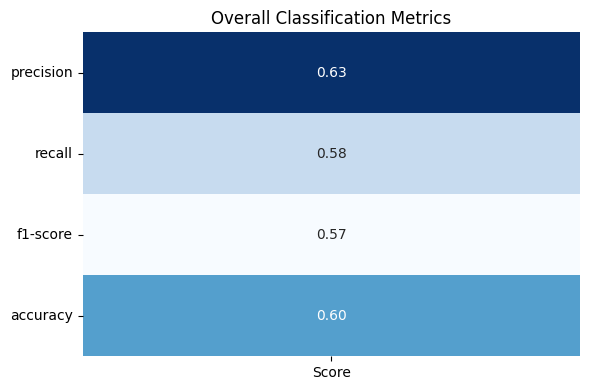

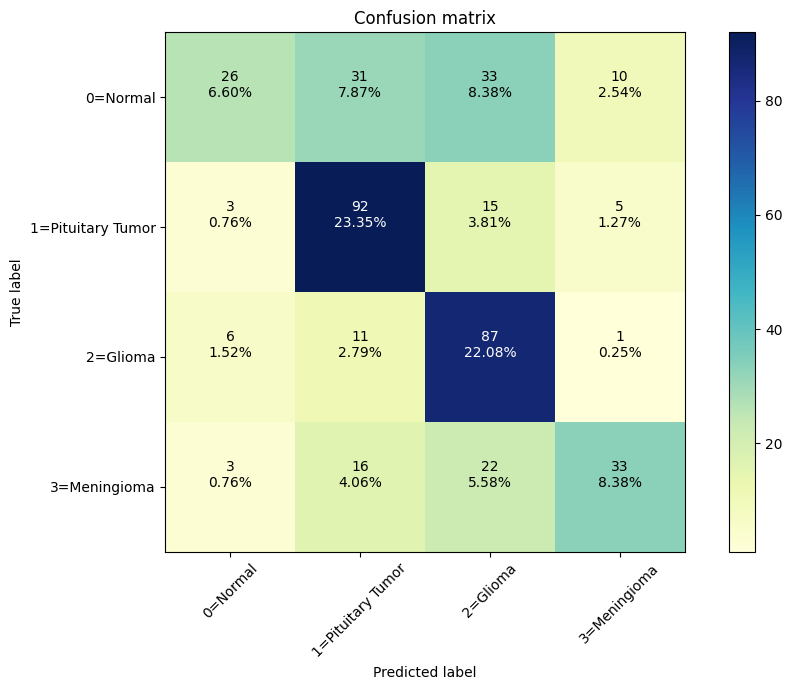


VALIDARE-TRAINING



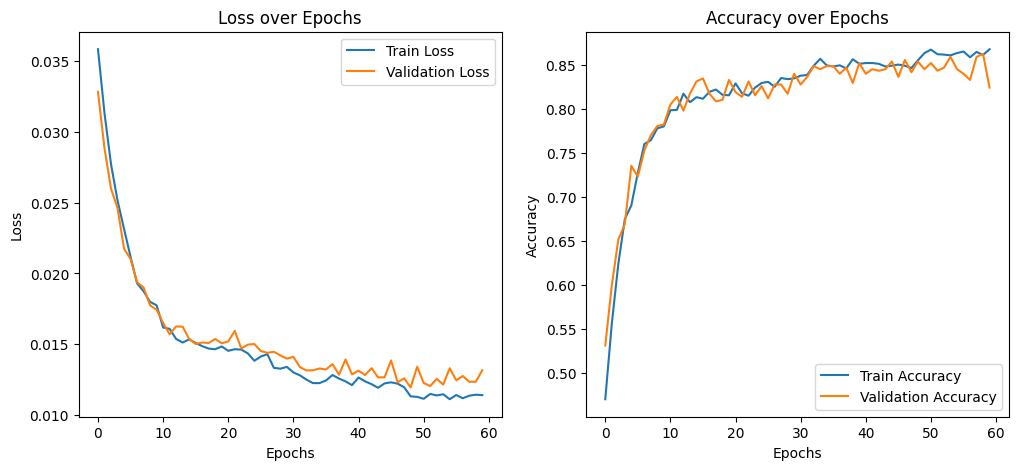

In [ ]:
CLA_label = {
    "Normal": 0,
    "Pituitary Tumor": 1,
    "Glioma": 2,
    "Meningioma": 3
}

# Raport de clasificare + matricea de confuzie
print("\nTESTING\n")

plot_classification_report(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm,  CLA_label)

print("\nVALIDARE-TRAINING\n")

# Graficele de acuratete si evolutia erorii
plot_train_val_graphs(loss_history, metric_history)